# **Binary Classification Task Using Tsetlin Machine (TM)**

**Table of Content:**


1.   Introduction
2.   Importing Essential Packages
3.   Loading Dataset
4. EDA: Exploratory Data Analysis
5. Feature Engineering
6. Machin Learning Modeling
7. Cross-Validation and Hyperparameter Tuning for the Random Forest Classifier
8. Tsetline Machine Modeling
9. Cross-Validation and Hyperparameter Tuning for the Tsetline Machine Classifier
10. Conclusion



## **1. Introduction**




In today's competitive business market, analyzing customer opinions about services is crucial for a company's survival. In this project, we will leverage a dataset from Kaggle containing airline passenger satisfaction surveys to develop an artificial intelligence model. Our goal is to predict passenger satisfaction and compare the efficacy of classical machine learning models with the Tsetlin Machine for this specific task.

**Business Question**: What strategies can we implement to retain loyal passengers and ensure the long-term sustainability of the airline?

## **2. Importing Essential Packages**

In [ ]:
! pip install -q kaggle

In [ ]:
!pip install pyTsetlinMachine

  Preparing metadata (setup.py) ... done
  Created wheel for pyTsetlinMachine: filename=pyTsetlinMachine-0.6.6-cp310-cp310-linux_x86_64.whl size=59497 sha256=119a8ace88698d246acd50eff89e277635fb38c2622afd82529a74d77dae2044
  Stored in directory: /root/.cache/pip/wheels/b0/b0/c5/07c4cb8bb93c5325bdc2c2a070b565f54df717d5d11f0c6802
Successfully built pyTsetlinMachine


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay ,accuracy_score ,classification_report, accuracy_score

from pyTsetlinMachine.tm import MultiClassTsetlinMachine
from pyTsetlinMachine.tools import Binarizer

## **3. Loading Dataset**

Data source: [Kaggle](https:///www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction/data)

In [ ]:
! mkdir ~/.kaggle
! cp kaggle1.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle1.json

! kaggle datasets download teejmahal20/airline-passenger-satisfaction

Dataset URL: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction
License(s): other
  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 102MB/s]


In [ ]:
! mkdir train
! unzip airline-passenger-satisfaction.zip -d train

Archive:  airline-passenger-satisfaction.zip
  inflating: train/test.csv          
  inflating: train/train.csv         


In [ ]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('train/train.csv')
df_test = pd.read_csv('train/test.csv')

df = pd.concat([df, df_test], ignore_index=True)

## **4. EDA: Exploratory Data Analysis**


The original dataset was divided into train and test sets from the beginning, with 103,904 records in the training data and 25,976 records in the test data. However, we concatenated these datasets to improve randomness. As a result, our combined data now has 129,880 rows and 24 columns.

Our target feature is "satisfaction," and we aim to predict the conditions under which passengers are satisfied with the airline.

In [ ]:
df.head(2)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      1298

Among the 25 features, one ("Unnamed: 0") can be removed as it functions as an index and does not provide useful information. Five features are categorical: Gender, Customer Type, Type of Travel, Class, and satisfaction. Additionally, one feature ("Arrival Delay") has 393 missing values. We fill these missing values with the median value of all arrival delays.

In [ ]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
df.isnull().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [ ]:
median_arrival_delay = df['Arrival Delay in Minutes'].median()
df['Arrival Delay in Minutes'].fillna(median_arrival_delay, inplace=True)

In [ ]:
df.describe()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,64940.500000,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.045465
std,37493.270818,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.416353
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32470.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64940.500000,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97410.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


The following figures display the distribution of categorical features, taking the satisfaction feature into account.

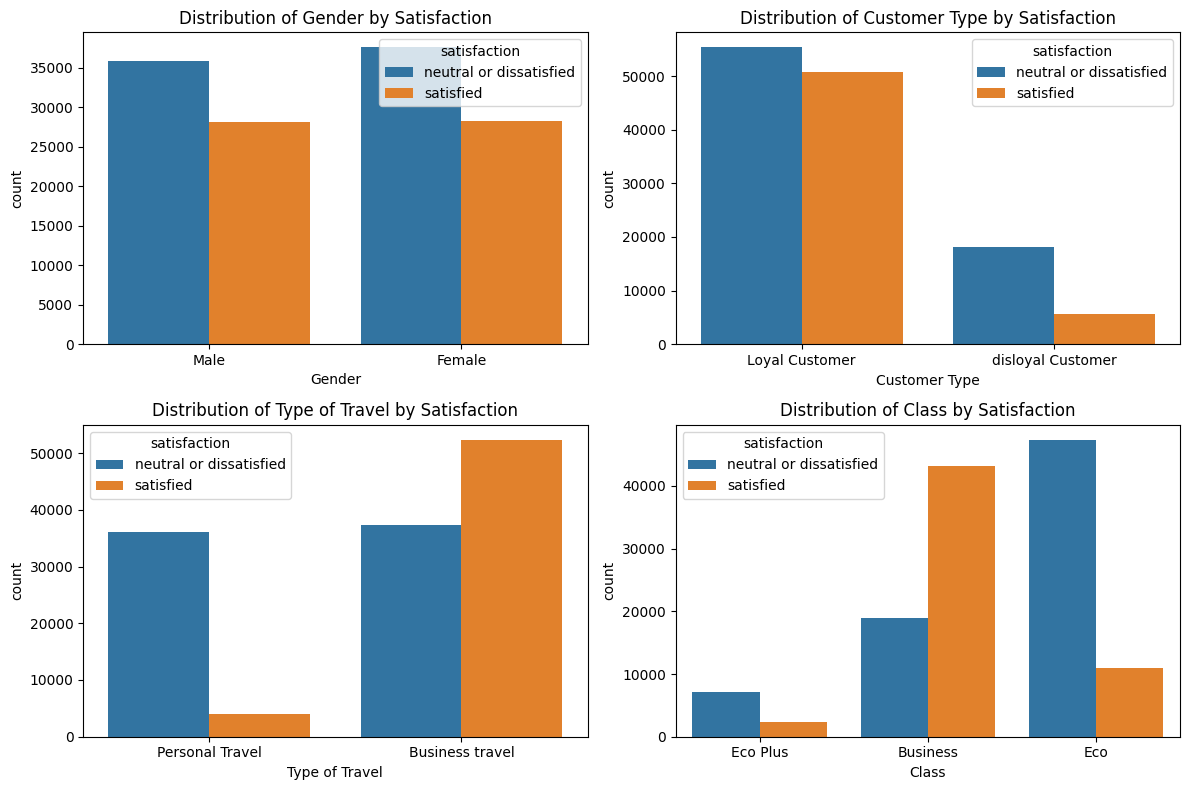

In [ ]:
columns_to_plot = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, col in enumerate(columns_to_plot):
    sns.countplot(x=col, hue='satisfaction', data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Satisfaction')

plt.tight_layout()
plt.show()

In [ ]:
df['satisfaction'].value_counts(normalize=True)

satisfaction
neutral or dissatisfied    0.565537
satisfied                  0.434463
Name: proportion, dtype: float64

The difference between the two classes is about 13 percent. Therefore we can consider the data relatively balanced.

## **5. Feature Engineering**

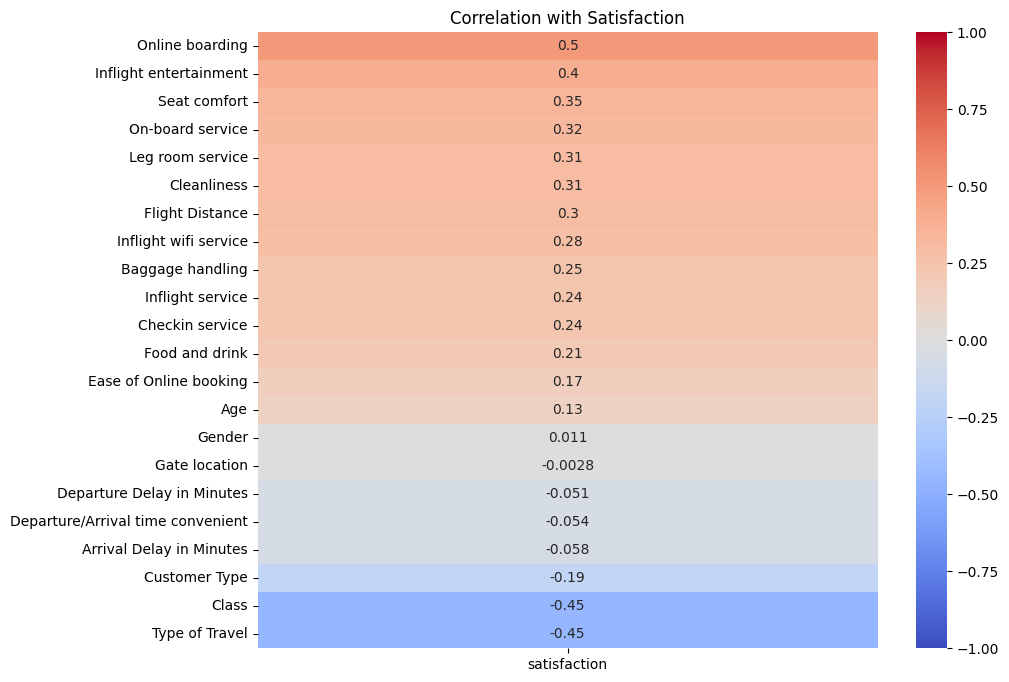

In [ ]:
features = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
            'Flight Distance', 'Inflight wifi service',
            'Departure/Arrival time convenient', 'Ease of Online booking',
            'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
            'Inflight entertainment', 'On-board service', 'Leg room service',
            'Baggage handling', 'Checkin service', 'Inflight service',
            'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

df_encoded = df.copy()
df_encoded.drop("id", axis = 1, inplace = True)

# Label encode the categorical features including 'satisfaction'
label_encoders = {}
for feature in features + ['satisfaction']:
    if df_encoded[feature].dtype == 'object':
        le = LabelEncoder()
        df_encoded[feature] = le.fit_transform(df_encoded[feature])
        label_encoders[feature] = le

# Scale the data from 0 to 1
scaler = MinMaxScaler()
df_encoded[features + ['satisfaction']] = scaler.fit_transform(df_encoded[features + ['satisfaction']])

# Calculate the correlation matrix
correlation_matrix = df_encoded[features + ['satisfaction']].corr()

# Extract the correlations with 'satisfaction'
satisfaction_correlations = correlation_matrix['satisfaction'].drop('satisfaction').sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(satisfaction_correlations.to_frame(), annot=True, cmap='coolwarm', vmax=1, vmin=-1, center=0)
plt.title('Correlation with Satisfaction')
plt.show()


To select features, we calculated the correlation between all features and satisfaction. We set a threshold of 0.28 for positive correlations and -0.19 for negative correlations. Based on this criterion, features such as Online boarding, Inflight entertainment, Seat comfort, On-board service, Leg room service, Cleanliness, Flight Distance, Customer Type, Class, and Type of Travel can be considered correlated with satisfaction.

On the other hand, some of these features are correlated with each other: Customer Type with Type of Travel; Type of Travel with Class; Class with Flight Distance; Inflight wifi service with Online boarding; Online boarding with Seat comfort and Cleanliness; Seat comfort with Inflight entertainment and Cleanliness; Inflight entertainment with On-board service; On-board service with Leg room service. Since we cannot remove all of them, we will drop Cleanliness from our features.

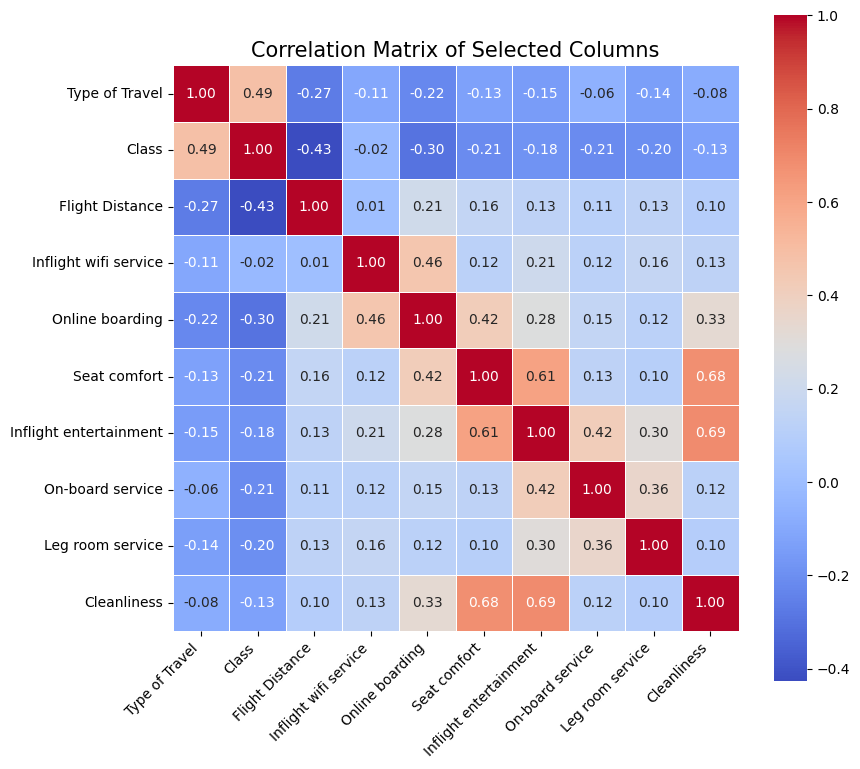

In [ ]:
columns_of_interest = ['Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Online boarding',
                       'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Cleanliness']

df_selected = df_encoded[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Draw the heatmap
plt.figure(figsize=(9, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, annot_kws={"size": 10})
plt.title('Correlation Matrix of Selected Columns', size=15)
plt.xticks(rotation=45, ha='right', size=10)
plt.yticks(rotation=0, size=10)
plt.tight_layout()
plt.show()

In [ ]:
# # List of columns to include in the plot
# columns_of_interest = ['Customer Type', 'Flight Distance', 'Inflight wifi service', 'Online boarding', 'Seat comfort',
#                        'Inflight entertainment', 'On-board service', 'Leg room service']

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# axes = axes.flatten()
# for i, col in enumerate(columns_of_interest):
#     sns.scatterplot(x=col, hue='satisfaction', data=df, ax=axes[i])
#     axes[i].set_title(f'Distribution of {col} by Satisfaction')

# plt.tight_layout()
# plt.show()

## **6. Machin Learning Modeling**

After selecting the features, we will classify our data using three different ML algorithms: Random Forest, Logistic Regression, and SVM, to determine which one performs better for our task.

In [ ]:
features_names = ['Customer Type', 'Type of Travel', 'Class','Flight Distance', 'Inflight wifi service', 'Online boarding',
                 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service']

X = df_encoded[features_names]
y = df_encoded['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.94     14564
         1.0       0.94      0.92      0.93     11412

    accuracy                           0.94     25976
   macro avg       0.94      0.93      0.93     25976
weighted avg       0.94      0.94      0.94     25976



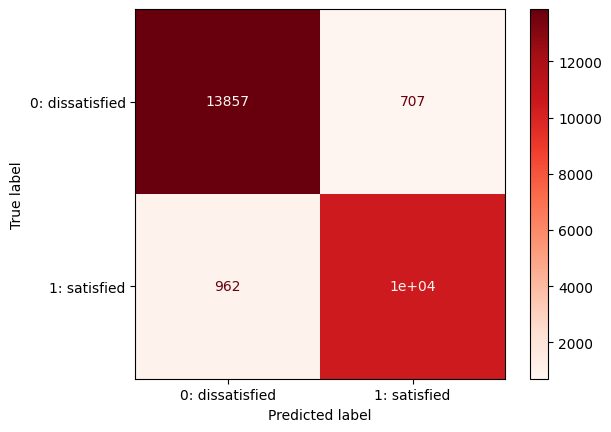

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds', display_labels = ["0: dissatisfied", "1: satisfied"])

Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     14564
         1.0       0.86      0.83      0.84     11412

    accuracy                           0.87     25976
   macro avg       0.86      0.86      0.86     25976
weighted avg       0.87      0.87      0.87     25976



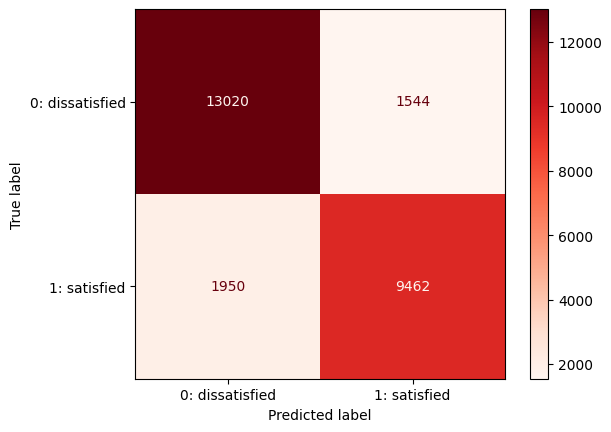

In [ ]:
LR_clf = LogisticRegression()

# Train the model
LR_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = LR_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds', display_labels = ["0: dissatisfied", "1: satisfied"])

Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.90      0.88     14564
         1.0       0.87      0.82      0.84     11412

    accuracy                           0.87     25976
   macro avg       0.87      0.86      0.86     25976
weighted avg       0.87      0.87      0.87     25976



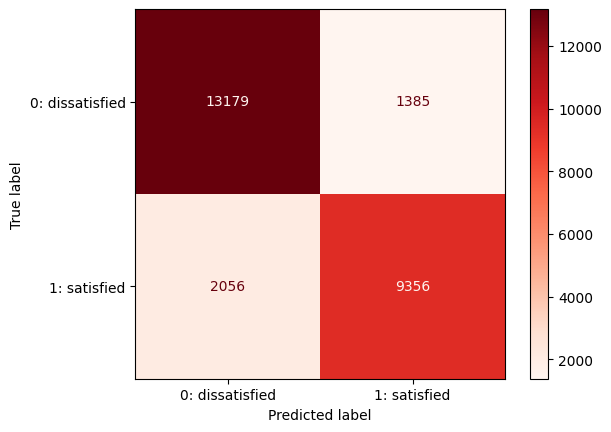

In [ ]:
svm_clf = svm.SVC(kernel='linear')

# Train the model
svm_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds', display_labels = ["0: dissatisfied", "1: satisfied"])

By comparing the F1-score among these algorithms, RandomForest achieves the highest accuracy at 94%.

## **7. Cross-Validation and Hyperparameter Tuning for the Random Forest Classifier**

In [ ]:
import sklearn
import sklearn.ensemble

parameters_grid = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [50, 100, 200]
}

# Definition of the model
model = GridSearchCV(sklearn.ensemble.RandomForestClassifier(), parameters_grid, scoring="recall", cv=5, n_jobs=-1)

# Start Training
model.fit(X_train, y_train)

print("Recall of best Random Forest classfier = {:.2f}".format(model.best_score_))
print("Best found hyperparameters of Random Forest classfier = {}".format(model.best_params_))

Recall of best Random Forest classfier = 0.92
Best found hyperparameters of Random Forest classfier = {'criterion': 'gini', 'n_estimators': 100}


After tuning the hyperparameters of Random Forest clasifier, which was our best model, we reached to recall 92%.

## **8. Tsetline Machine Modeling**

In this section, we classified our data using the Tsetlin Machine. Firstly, we selected features based on their correlation with the target variable. Secondly, we split our data into training and test sets, and binarized our features. Finally, we constructed a Tsetlin Machine model and applied it to our dataset, achieving an F1-score of 0.51

In [ ]:
df_binarized = pd.get_dummies(df, dtype=float)
df_binarized.drop('satisfaction_neutral or dissatisfied', axis = 1, inplace = True)

In [ ]:
# Scale the data from 0 to 1
scaler = MinMaxScaler()
df_binarized_scaled = pd.DataFrame(scaler.fit_transform(df_binarized), columns=df_binarized.columns)

# Calculate the correlation matrix
correlation_matrix = df_binarized_scaled.corr()

# Extract the correlations with 'satisfaction'
satisfaction_correlations = correlation_matrix['satisfaction_satisfied'].drop('satisfaction_satisfied').sort_values(ascending=False)

In [ ]:
# Filter correlations greater than 0.28
strong_correlations = satisfaction_correlations[satisfaction_correlations.abs() > 0.28]
print("Strong correlations (abs > 0.28):")
print(strong_correlations)

Strong correlations (abs > 0.28):
Class_Business                    0.502476
Online boarding                   0.501749
Type of Travel_Business travel    0.449861
Inflight entertainment            0.398234
Seat comfort                      0.348829
On-board service                  0.322205
Leg room service                  0.312424
Cleanliness                       0.307035
Flight Distance                   0.298085
Inflight wifi service             0.283460
Class_Eco                        -0.449386
Type of Travel_Personal Travel   -0.449861
Name: satisfaction_satisfied, dtype: float64


In [ ]:
# Scale the data from 0 to 1
scaler = MinMaxScaler()
df_binarized_scaled = pd.DataFrame(scaler.fit_transform(df_binarized), columns=df_binarized.columns)

# Calculate the correlation matrix
correlation_matrix = df_binarized_scaled.corr()

In [ ]:
features_names_TsM = strong_correlations.index

In [ ]:
X = df_binarized_scaled[features_names_TsM]
y = df_binarized_scaled['satisfaction_satisfied']

In [ ]:
# Convert the DataFrame to a NumPy array
X_array = X.values

b = Binarizer()
b.fit(X_array)
X_binarized = b.transform(X_array)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_binarized, y, test_size=0.2, shuffle=True)

Accuracy: 0.51
Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.59      0.58     14654
         1.0       0.44      0.41      0.42     11322

    accuracy                           0.51     25976
   macro avg       0.50      0.50      0.50     25976
weighted avg       0.51      0.51      0.51     25976



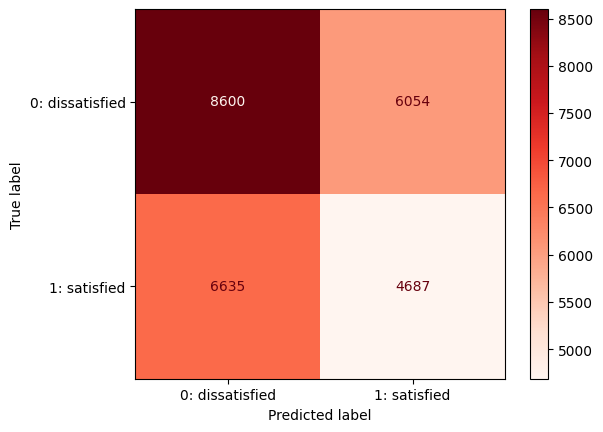

In [ ]:
tsetlin_machine = MultiClassTsetlinMachine(10, 15, 3, boost_true_positive_feedback=0)

# Training of the Tsetlin Machine in batch mode. The Tsetlin Machine can also be trained online
tsetlin_machine.fit(X_train, y_train, epochs=100)

y_predicted = tsetlin_machine.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds', display_labels = ["0: dissatisfied", "1: satisfied"])

# **9. Cross-Validation and Hyperparameter Tuning for the  Tsetline Machine Classifier**

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TsetlinMachineClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, number_of_clauses=10, number_of_states=15, threshold=3, boost_true_positive_feedback=0):
        self.number_of_clauses = number_of_clauses
        self.number_of_states = number_of_states
        self.threshold = threshold
        self.boost_true_positive_feedback = boost_true_positive_feedback
        self.model = None

    def fit(self, X, y, epochs=100):
        self.model = MultiClassTsetlinMachine(self.number_of_clauses, self.number_of_states, self.threshold, self.boost_true_positive_feedback)
        self.model.fit(X, y, epochs=epochs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [ ]:
param_grid = {
    'number_of_clauses': [10, 20, 30],
    'number_of_states': [15, 30, 45],
    'threshold': [3, 5, 7],
    'boost_true_positive_feedback': [0, 1]
}

grid_search = GridSearchCV(TsetlinMachineClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Use the best estimator to predict and evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds', display_labels=["0: dissatisfied", "1: satisfied"])

Fitting 5 folds for each of 54 candidates, totalling 270 fits


## **10. Conclusion**

Although the Tsetlin Machine is a robust algorithm for classification, classical machine learning algorithms have shown better performance on our dataset.
To improve accuracy, we can consider adding more features and tuning hyperparameters.